In [1]:
# Modulos básicos
import numpy as np
import time
#from pylab import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange, tqdm_notebook
# Modulo para manejo de fecha
from datetime import datetime, timedelta
# Modulos para astrofisica/solar
import astropy
from sunpy.net import vso
import astropy.units as u
from sunpy.map import Map
from astropy.io import fits # to fix headers
# Custom-made methods and classes for fixing headers
from lib.CompatMaps import sinehpc_wcs_frame_mapping

In [ ]:
# Habilitar JS en jupyter (correr en shell como root)
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

# Data structure

Data is acquired using another jupyter notebook that is in the same repository as this one (check https://github.com/ijpulidos/solar-physics-ex/) and it's called Acquiring_Data.ipynb

The structure of the data sets downloaded with that notebook is as follows (relative to the directory of this notebook):

    data
    ├── set1
    │   ├── hmi_ic_45s_2012_01_29_00_01_30_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2012_01_29_00_16_30_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2012_01_29_00_31_30_tai_continuum.fits.fits
    |   ...
    │   └── hmi_ic_45s_2012_01_30_14_46_30_tai_continuum.fits.fits
    ├── set2
    │   ├── hmi_ic_45s_2013_03_04_00_01_30_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2013_03_04_00_44_15_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2013_03_04_00_45_00_tai_continuum.fits.fits
    |   ...
    │   └── hmi_ic_45s_2013_03_09_17_12_45_tai_continuum.fits.fits
    ├── set3
    │   ├── hmi_ic_45s_2014_09_23_00_02_15_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2014_09_23_00_03_00_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2014_09_23_00_03_45_tai_continuum.fits.fits
    |   ...
    │   └── hmi_ic_45s_2014_09_28_23_06_00_tai_continuum.fits.fits
    ├── set4
    │   ├── hmi_ic_45s_2015_09_03_00_01_30_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2015_09_03_00_02_15_tai_continuum.fits.fits
    │   ├── hmi_ic_45s_2015_09_03_05_46_30_tai_continuum.fits.fits
    |   ...
    │   └── hmi_ic_45s_2015_09_08_22_56_15_tai_continuum.fits.fits
    ...

    12 directories, 1290 files (in my case)

In [2]:
basepath = !pwd
fits_files = !ls data/set1/*.fits  # Quedan con el path data/*.fits 
np.shape(fits_files)

(138,)

# Arreglando headers de archivos FITS descargados
Desafortunadamente para ver los resultados hay muchas imágenes que no tienen los headers correctos, entonces es necesario hacer algo como lo que se muestra en este enlace para corregir estos problemas: http://docs.sunpy.org/en/latest/generated/gallery/gallery/hmi_synoptic_maps.html and specially the updated example in: https://gist.github.com/Cadair/cbc73dc7888b9bae5d06708270aedd68

In [ ]:
#from IPython.display import clear_output
# Read header and data from all fits files programatically
#i = 0  # index for files
for file in fits_files:
    fitsfile = fits.open(basepath[0]+'/'+file)
    fitsfile.verify('fix')
    header = fitsfile[1].header
    del fitsfile
    #time.sleep(1)
    #header.values

In [ ]:
# Fixing headers programatically
for file in tqdm_notebook(fits_files):
    print(file)
    fitsfile = fits.open(basepath[0]+'/data/'+file)
    fitsfile.verify('fix')
    header = (fitsfile[0].header)
    if header['CUNIT2'] == 'sin(latitude)' and header['CTYPE1'] == 'CRLN-CEA' and header['CTYPE2'] == 'CRLT-CEA':
        tqdm.write("Wrong header information found in %s. Changing..." % file)
        #print("Wrong header information found in %s. Changing..." % file)
        header['CUNIT2'] = 'deg'
        header['CTYPE1'] == 'CSLN-CEA'
        header['CTYPE2'] == 'CSLT-CEA'
    try:
        if header['HGLN_OBS'] == 'nan':
            del header['HGLN_OBS']
    except KeyError:
        #tdqm.write("Warning: Key not found, letting it pass.")
        print("Warning: Key not found, letting it pass.")
        pass
    if header.get('CD1_2') == None:
        header['CD1_2'] = 0
    if header.get('CD2_1') == None:
        header['CD2_1'] = 0

In [ ]:
# NOT NEEDED - KEPT FOR REMEMBERING IN THE OCCASION THIS IS NEEDED
#astropy.wcs.utils.WCS_FRAME_MAPPINGS.append([sinehpc_wcs_frame_mapping]) # Adding the map to the WCS astropy utils module

# Graficar visualizar resultados de la búsqueda

In [ ]:
# Esto es para ver alguna imagen en específico, con coordenadas y todo
%matplotlib inline
plt.figure(figsize=(16,9))
# Making the map 
fitsfile = fits.open(basepath[0]+'/'+fits_files[10])
fitsfile.verify('fix')
data = fitsfile[1].data
header = fitsfile[1].header
m = Map((data, header))
m.peek()
# Set the colorbar properties.
#m.plot_settings['cmap'] = 'hmimag'
#m.plot_settings['norm'] = plt.Normalize(-1500, 1500)

In [ ]:
# Para dibujar perfiles
plt.plot(data[2048,:])
plt.xlabel('Pixeles')
plt.ylabel('Intensidad')
plt.grid(True)
plt.show()

# Widget to see time evolution

Since we are really dealing with a "big" sequence of images in FITS format it is helpful to have a widget to actually see the sequence and check wether the time range chosen is correct and see what to expect beforehand.

In [ ]:
%matplotlib inline
from IPython.html.widgets import *
number_of_images = len(fits_files)

def image_sequence(image):
    #fitsfile = fits.open(basepath[0]+'/data/'+fits_files[0])
    #print(fitsfile)
    fitsfile = fits.open(basepath[0]+'/'+fits_files[image])
    fitsfile.verify('fix')
    plt.figure(figsize=(16,9))
    plt.imshow(fitsfile[1].data)
    plt.title(fitsfile.filename())
    plt.show()
    
interact(image_sequence, image=(0,number_of_images-1,1), continuous_update=False)

# Procesamiento de datos

Aplicaré algo de lo que dicen acá http://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/ para detectar manchas simultáneamente y hacer una estadística automática y "grande".

Tengo que aplicar lo de esa página pero con oscuros, no con claros. Por ahora se aplica a una imágen en específico, luego hay que aplicarla a todas las imágenes y que lance los datos de velocidad/trayectoria.

## Algoritmo:
En términos generales el algoritmo es como sigue:

1) Remover background/borde oscuro

2) Suavizar la imagen aplicando un filtro Gaussiano

3) "Binarizando" con umbral

4) Labeling the spots

5) Obteniendo centros de masa (en unidades arcsec)



In [3]:
# Módulos básicos para detectar contornos/manchas
from imutils import contours
from skimage import measure
import skimage
#import numpy as np
import imutils
import cv2

### 1) Remover background/borde oscuro, de medidas en casos anteriores sabemos que

3851 px = Diametro horizontal sol

3967 - 117 = 3850 px = Diametro vert. sol

Recordar que X -> vertical y Y -> horizontal, para tratamiento de imágenes.

La imagen es de 4096 x 4096 y si asumimos que la imagen está bien centrada en 2048, entonces podemos hacer un círculo de radio $r\le 3850/2 \approx 1925$ pixeles, tal que lo que esté por fuera de este círculo se vuelva "nan" y lo de adentro se quede igual.

Más información en: http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array

In [4]:
# Borrar background/contorno negro
## se hace una máscara circular con centro = (2048, 2048)
centerx, centery = 2048, 2048
r = 1920  # radius set1
# r = 1850 # radius set2
# r = 1810 # radius set3
# r = 1810 # radius set4
#r = 1860 # radius set5
#r = 1860 # radius set6
#r = 1850 # radius set7
y,x = np.ogrid[-centerx:4096-centerx, -centery:4096-centery]
mask = x*x + y*y > r*r  # circular mask
#array = np.ones((n, n))
#array[mask] = 255

In [5]:
# FUNCIONES BÁSICAS PARA HACER LO QUE NECESITO (deberían ir en un .py aparte - WIP)
# 
def extract_fits_data(index):
    '''
    Function to extract data from fitsfile given just an index
    '''
    fitsfile = fits.open(basepath[0]+'/'+fits_files[index])
    fitsfile.verify('fix')
    return fitsfile[1].header, fitsfile[1].data

 [astropy.io.fits.verify]


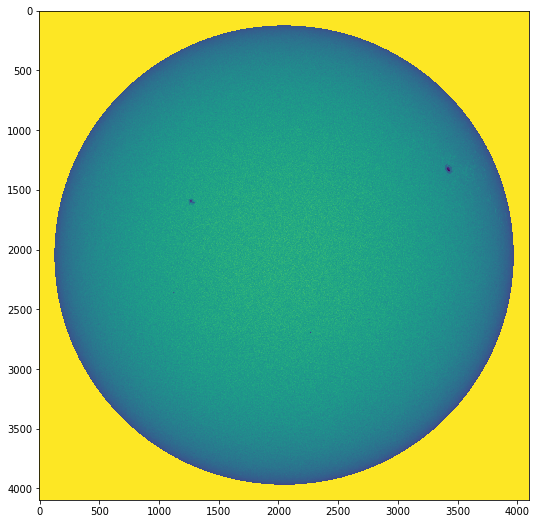

In [6]:
# Apply mask
header, data = extract_fits_data(2)
sun_map = Map((data, header))
data[mask] = 100000
# plot data to check background removal
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(data)
#plt.figure()
#plt.imshow(extract_fits_data(14))
#plt.show()

### 2) Suavizar la imagen aplicando un filtro Gaussiano

In [12]:
# Just blur the image with a gaussian filter
blurred = cv2.GaussianBlur(data, (31, 31), 0)
#blurred = cv2.GaussianBlur(data, (11, 11), 0) # set 4

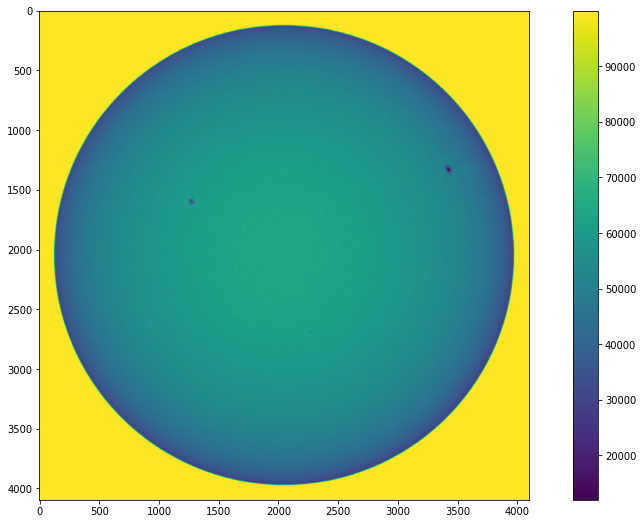

In [13]:
# Plot blurred image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(blurred)
plt.colorbar()
plt.show()

Al parecer usar 31 en el filtro Gaussiano da buenos resultados con esta imagen que tiene algunas manchas MUY pequeñas, de tal forma que puedo descartar todas las cosas que sean más brillantes a 4.5e4 (45000), detectando así solo las dos manchas grandes. Porque no puedo garantizar que las manchas pequeñas siempre sean visibles.

### 3) "Binarizando" con umbral

In [14]:
thresh = cv2.threshold(blurred, 29250, 74078, cv2.THRESH_BINARY)[1]

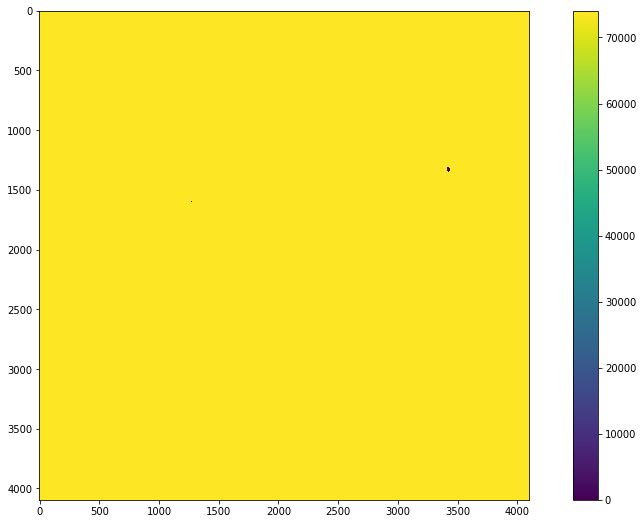

In [17]:
# Plot binary image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(thresh)
plt.colorbar()
plt.show()

In [16]:
# Removing small "blobs" with erode and dilate
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

### 4) Labeling the spots
Using https://en.wikipedia.org/wiki/Connected-component_labeling

In [18]:
labels = measure.label(thresh, neighbors=8, background=74078)
mask = np.zeros(thresh.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue
 
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 30: # set1
    #if numPixels > 20: # set4
    #if numPixels > 200: # set5
    #if numPixels > 200: # set6
    #if numPixels > 50: # set7
        mask = cv2.add(mask, labelMask)

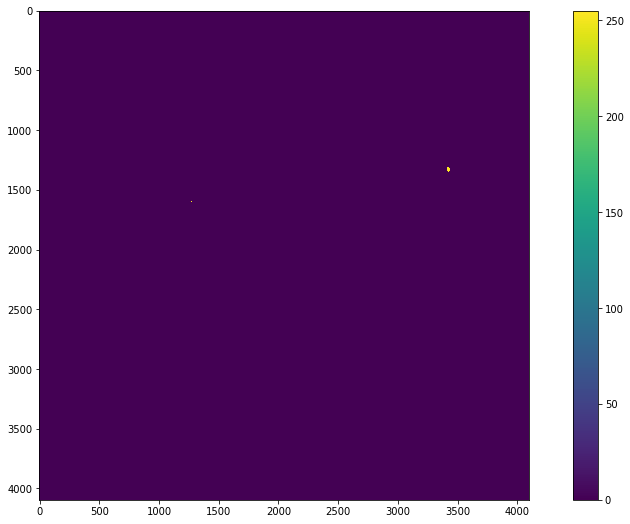

In [19]:
# Plot the resulting mask
# Plot binary image
%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(mask)
plt.colorbar()
plt.show()

In [20]:
image = data.astype("uint8")
# find the contours in the mask, then sort them from left to right
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = contours.sort_contours(cnts)[0]
#cv2.namedWindow("Image", cv2.WINDOW_NORMAL or cv2.WINDOW_AUTOSIZE)  # To show window that's larger than screen 
# loop over the contours
centros_de_masa = []
for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
    (x, y, w, h) = cv2.boundingRect(c)
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    print(cX,cY)
    centros_de_masa.append([cX, cY])
    cv2.circle(image, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
    cv2.putText(image, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
#cv2.imshow("Image",image)
#cv2.waitKey(0)

1271.0 1598.6666259765625
3422.0 1331.5


### 5) Obteniendo centros de masa
De lo anterior se obtienen centros en pixeles, ahora tengo que pasar estos centros a centros de masa en coordenadas de sunpy (arcsec).

In [21]:
# hago mapa de SunPy
sun_map = Map((data, header))

In [22]:
for i in centros_de_masa:
    print(sun_map.pixel_to_data(i[0]*u.pix, i[1]*u.pix))

(<Longitude 389.81247636713766 arcsec>, <Latitude 223.1316761056224 arcsec>)
(<Longitude -694.6108677394705 arcsec>, <Latitude 359.17096296953525 arcsec>)


## Transforming coordinates
Coordinates from the data of HMI are in Helioprojective-cartesian, to account for changes in the perspective of the Sun since the observer is sometimes above Sun's equator, sometimes below and the north pole is not always the highest point in the image (check http://jgiesen.de/sunrot/index.html for visualization and explanations) we have to perform a coordinate transformation to use Stonyhurst-Heliocentric coordinates. Fortunately astropy does this for us.

Based on code from http://docs.sunpy.org/en/latest/generated/gallery/tutorials/skip_SDO_to_STEREO_Coordinate_Conversion.html#sphx-glr-generated-gallery-tutorials-skip-sdo-to-stereo-coordinate-conversion-py

In [23]:
sun_map.coordinate_frame

<Helioprojective Frame (D0=147324152897.0 m, dateobs=2012-01-29 00:30:25.900000, L0=0.0 deg, B0=-5.758757 deg, rsun=695508.0 km)>

In [24]:
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.coordinates
import sunpy.coordinates.wcs_utils

In [25]:
CoM_pix = centros_de_masa*u.pix # Transforming CoM to astropy pix unit
CoM_arcsec = [sun_map.pixel_to_data(*i) for i in CoM_pix] # Then transforming them to arcsec
#print(CoM_arcsec)
hpc_coords = SkyCoord([*CoM_arcsec], frame=sun_map.coordinate_frame)  # Built skycoord object with sunspots/CoM coords
#print(hpc_coords)
hgs_coords = hpc_coords.transform_to('heliographic_stonyhurst')  # Transform from HPC to HGS coordinate system
print(hgs_coords)
type(hgs_coords.data)

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:30:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.73347573,   7.92650434,  695508.00000399),
     (-48.34103282,  17.80942647,  695508.00000139)]>


sunpy.coordinates.representation.SphericalWrap180Representation

In [26]:
hgs_coords.data[1].lon.deg # acceder a dato numérico "puro" de lat o lon en grados

-48.34103282400773

In [28]:
for i in hgs_coords.data:
    print(i.lon.deg)
    print(i.lat.deg)

23.733475726303862
7.9265043386397105
-48.34103282400773
17.809426468015396


# Aplicando a todo el set

Lo anterior consiste en el laboratorio para ver los diferentes pasos por separado y entender los resultados de cada uno de los pasos del algoritmo. A continuación se unen todos estos pasos y se aplican a TODO el conjunto de imágenes.

## Algoritmo:
En términos generales el algoritmo es como sigue:

1) Remover background/borde oscuro (aplicar máscara)

2) Suavizar la imagen aplicando un filtro Gaussiano

3) "Binarizando" con umbral

4) Labeling the spots

5) Obteniendo centros de masa (en unidades de pixeles)

6) Transformar coordenadas a HGS (Heliographic-Stonyhurst)

7) Obtener datos latitud/longitud en degrees

8) Guardar datos en archivos de texto

### Nota
Para cada set de datos es necesario aplicar diferentes valores para los parámetros del procesamiento de imágenes, entonces se usará un archivo de configuración (del tipo ConfigParser) para leer y guardar estos parámetros para cada set.

In [ ]:
# Configparser to parse options for each set of data
from configparser import ConfigParser

In [ ]:
# Read data set parameters from config file
config = ConfigParser()
# TODO

In [ ]:
def plot_data(data, title):
    %matplotlib inline
    plt.figure(figsize=(16,9))
    plt.title(title)
    plt.imshow(data)
    plt.colorbar()
    plt.show()

In [29]:
number_of_spot = 1  # Initiliazing variable set1
#number_of_spot = 0 # Initiliazing variable set4
#number_of_spot = 0 # Initiliazing variable set5
#number_of_spot = 0 # Initiliazing variable set6
#number_of_spot = 0 # Initiliazing variable set7
#number_of_spot = 0 # Initiliazing variable set8
#number_of_spot = 0 # Initiliazing variable set9
#number_of_spot = 1 # Initiliazing variable set10
centros_de_masa = 0 # Initializing variable

longitudes = []
latitudes = []
datetimes = []

#for imag_idx in range(1,140):  # For testing purposes
#for imag_idx in [1,140]:
#for imag_idx in range(15,len(fits_files)): # set 4
for imag_idx in range(len(fits_files)):
    # 0) Extract header and data and make map
    header, data = extract_fits_data(imag_idx)
    sun_map = Map((data, header))
    
    # Prior to applying mask
    # Borrar background/contorno negro
    ## se hace una máscara circular con centro = (2048, 2048)
    centerx, centery = 2048, 2048
    r = 1920  # radius set1
    #r = 1850  # radius set4
    # r = 1860  # radius set5
    #r = 1860  # radius set6
    #r = 1850  # radius set7
    #r = 1850  # radius set8
    #r = 1850  # radius set9
    #r = 1850  # radius set10
    y,x = np.ogrid[-centerx:4096-centerx, -centery:4096-centery]
    mask = x*x + y*y > r*r  # circular mask
    #array = np.ones((n, n))
    #array[mask] = 255
        
    # 1) Apply mask
    data[mask] = 100000
    #plot_data(data, "data masked") # plot data masked
    
    # 2) Apply Gaussian filter
    blurred = cv2.GaussianBlur(data, (31, 31), 0) # set1
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set4
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set5
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set6
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set7
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set8
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set9
    #blurred = cv2.GaussianBlur(data, (11, 11), 0) # set10
    #plot_data(blurred, "data blurred") # plot data masked
    
    # 3) Binarizing
    thresh = cv2.threshold(blurred, 29250, 74078, cv2.THRESH_BINARY)[1]  # set1
    #thresh = cv2.threshold(blurred, 28000, 74078, cv2.THRESH_BINARY)[1]  # set2
    #thresh = cv2.threshold(blurred, 28000, 74078, cv2.THRESH_BINARY)[1]  # set3
    #thresh = cv2.threshold(blurred, 27000, 74078, cv2.THRESH_BINARY)[1]  # set4
    #thresh = cv2.threshold(blurred, 29000, 74078, cv2.THRESH_BINARY)[1]  # set5
    #thresh = cv2.threshold(blurred, 27000, 74078, cv2.THRESH_BINARY)[1]  # set6
    #thresh = cv2.threshold(blurred, 26000, 74078, cv2.THRESH_BINARY)[1]  # set7
    #thresh = cv2.threshold(blurred, 26000, 74078, cv2.THRESH_BINARY)[1]  # set8
    #thresh = cv2.threshold(blurred, 26000, 74078, cv2.THRESH_BINARY)[1]  # set9
    #thresh = cv2.threshold(blurred, 22000, 74078, cv2.THRESH_BINARY)[1]  # set10
    ## Removing small "blobs" with erode and dilate
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    #plot_data(thresh, "data binarized") # plot data masked
    
    # 4) Labeling and computing center in pixels
    labels = measure.label(thresh, neighbors=8, background=74078)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue

        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 30: # set1
        #if numPixels > 50: # set4
        #if numPixels > 200: # set5
        #if numPixels > 200: # set6
        #if numPixels > 250: # set7
        #if numPixels > 250: # set8
        #if numPixels > 250: # set9
        #if numPixels > 50: # set10
            mask = cv2.add(mask, labelMask)
    image = data.astype("uint8")
    # 5) Obteniendo centros de masa (en pixeles)
    # find the contours in the mask, then sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = contours.sort_contours(cnts)[0]
    #cv2.namedWindow("Image", cv2.WINDOW_NORMAL or cv2.WINDOW_AUTOSIZE)  # To show window that's larger than screen 
    # loop over the contours
    centros_de_masa_old = centros_de_masa
    centros_de_masa = []
    number_of_spot_old = number_of_spot
    for (number_of_spot, c) in enumerate(cnts):
        # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        #print(cX,cY)
        # cX and cY I have to transform to HGS coords
       
        # 6) Transforming coordinates
        centros_de_masa.append([cX, cY])        
        CoM_pix = centros_de_masa*u.pix # Transforming CoM to astropy pix unit
        CoM_arcsec = [sun_map.pixel_to_data(*i) for i in CoM_pix] # Then transforming them to arcsec
        #print(CoM_arcsec)
        hpc_coords = SkyCoord([*CoM_arcsec], frame=sun_map.coordinate_frame)  # Built skycoord object with sunspots/CoM coords
        #print(hpc_coords)
        hgs_coords = hpc_coords.transform_to('heliographic_stonyhurst')  # Transform from HPC to HGS coordinate system
        print(hgs_coords)
        #type(hgs_coords.data)
        
        cv2.circle(image, (int(cX), int(cY)), int(radius), (0, 0, 255), 3)
        cv2.putText(image, "#{}".format(number_of_spot + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    print("Image index: ", imag_idx)
    print("Detected ", number_of_spot+1, " spots.")
    if number_of_spot_old != number_of_spot:
        print("Last index image calculated: ", imag_idx)
        raise ValueError("Number of spots detected different from before. Stoping calculation.")
        
    # 7) Getting centers of mass in lat,long (deg)
    # hago mapa de SunPy
    #sun_map = Map((data, header))
    longitude_temp = []
    latitude_temp = []
    for i in hgs_coords.data:
        print(i.lon.deg)
        print(i.lat.deg)
        longitude, latitude = i.lon.deg, i.lat.deg  # pair longitude, latitude for a single spot
        longitude_temp.append(longitude)
        latitude_temp.append(latitude)
        #print(longitude, latitude)
    #print(longitude_temp)
    longitudes.append(longitude_temp)
    latitudes.append(latitude_temp)
    datetimes.append(sun_map.date)
    
        
    # Borrar todas las variables para evitar errores
    del(sun_map, header, mask, data, blurred, thresh, image, longitude_temp, hpc_coords, hgs_coords)

WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:00:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.4565573,  7.92371454,  695508.00000193)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:00:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.4565573 ,   7.92371454,  695508.00000193),
     (-48.56290192,  17.7813695 ,  695507.99999994)]>
Image index:  0
Detected  2  spots.
23.456557303910873
7.923714541541935
-48.562901924289626
17.781369500134815


: VerifyWarning:         Card 'CRDER1' is not FITS standard (invalid value string: 'nan').  Fixed 'CRDER1' card to meet the FITS standard. [astropy.io.fits.verify]
 [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:15:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.60291584,  7.9311155,  695507.99999914)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:15:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.60291584,   7.9311155 ,  695507.99999914),
     (-48.47732887,  17.80834008,  695508.00000233)]>
Image index:  1
Detected  2  spots.
23.602915843839043
7.931115495787562


-48.47732886673987
17.80834007689166
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:30:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.73347573,  7.92650434,  695508.00000399)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:30:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.73347573,   7.92650434,  695508.00000399),
     (-48.34103282,  17.80942647,  695508.00000139)]>
Image index:  2
Detected  2  spots.
23.733475726303862
7.9265043386397105
-48.34103282400773
17.809426468015396


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:45:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.86827981,  7.9113792,  695507.99999586)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:45:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.86827981,   7.9113792 ,  695507.99999586),
     (-48.19399216,  17.79874826,  695507.99999675)]>
Image index:  3
Detected  2  spots.
23.868279806029
7.91137920019169
-48.19399216086762
17.798748263396153


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:59:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.9947872,  7.91411243,  695508.00000293)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 00:59:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.9947872 ,   7.91411243,  695508.00000293),
     (-48.05063934,  17.78428941,  695507.99999839)]>
Image index:  4
Detected  2  spots.
23.994787198008805
7.914112431421944
-48.05063933973564
17.784289408265707


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:00:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 23.99891271,  7.91298361,  695508.00000347)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:00:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 23.99891271,   7.91298361,  695508.00000347),
     (-47.9962663 ,  17.76389362,  695508.00000257)]>
Image index:  5
Detected  2  spots.
23.99891271239818
7.91298360815091
-47.996266303136785
17.76389362303734


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:14:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 24.13915019,  7.91174214,  695507.9999978)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:14:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 24.13915019,   7.91174214,  695507.9999978 ),
     (-47.91794333,  17.79134407,  695507.99999976)]>
Image index:  6
Detected  2  spots.
24.13915018950661
7.91174213839336
-47.917943332534215
17.791344074734557


WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:15:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 24.14161007,  7.91589301,  695507.99999924)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:15:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 24.14161007,   7.91589301,  695507.99999924),
     (-47.86421037,  17.7714066 ,  695507.99999344)]>
Image index:  7
Detected  2  spots.
24.141610072290486
7.915893005056136
-47.864210373190176
17.771406598374288


: VerifyWarning:         Card 'SOURCE' is not FITS standard (invalid value string: "'hmi.lev1[:#32943261,#32943237,#32943213,#32943285,#32943309,#32943333").  Fixed 'SOURCE' card to meet the FITS standard. [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:29:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 24.29190258,  7.91875255,  695508.00000085)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:29:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 24.29190258,   7.91875255,  695508.00000085),
     (-47.74685926,  17.77525846,  695507.99999992)]>
Image index:  8
Detected  2  spots.
24.29190258496155
7.9187525530299885
-47.74685925861972
17.775258461010633


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:30:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 24.29161255,  7.91913313,  695508.00000036)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:30:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 24.29161255,   7.91913313,  695508.00000036),
     (-47.77724313,  17.79403313,  695507.99999532)]>
Image index:  9
Detected  2  spots.
24.291612547511473
7.9191331335100905
-47.77724312694139
17.79403313388004


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:44:41): (lon, lat, radius) in (deg, deg, km)
    ( 24.42387799,  7.92700471,  695508.00000264)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:44:41): (lon, lat, radius) in (deg, deg, km)
    [( 24.42387799,   7.92700471,  695508.00000264),
     (-47.66556874,  17.8042174 ,  695507.99999972)]>
Image index:  10
Detected  2  spots.
24.42387799327347
7.927004706278613
-47.66556873601051
17.804217404413656


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:59:41): (lon, lat, radius) in (deg, deg, km)
    ( 24.57077673,  7.91749763,  695508.00000055)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 01:59:41): (lon, lat, radius) in (deg, deg, km)
    [( 24.57077673,   7.91749763,  695508.00000055),
     (-47.49958876,  17.78734695,  695507.99999474)]>
Image index:  11
Detected  2  spots.
24.570776726867905
7.91749763344197
-47.4995887596525
17.787346951604455


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:14:41): (lon, lat, radius) in (deg, deg, km)
    ( 24.70241835,  7.91576259,  695507.99999946)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:14:41): (lon, lat, radius) in (deg, deg, km)
    [( 24.70241835,   7.91576259,  695507.99999946),
     (-47.41607398,  17.80969908,  695507.99999828)]>
Image index:  12
Detected  2  spots.
24.70241835290493
7.91576258845558
-47.41607398019213
17.809699082043636


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:29:41): (lon, lat, radius) in (deg, deg, km)
    ( 24.83521553,  7.90961322,  695507.99999958)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:29:41): (lon, lat, radius) in (deg, deg, km)
    [( 24.83521553,   7.90961322,  695507.99999958),
     (-47.22185945,  17.78253804,  695507.9999987 )]>
Image index:  13
Detected  2  spots.
24.835215534373685
7.909613216872606
-47.22185945194236
17.78253803583959


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:43:56): (lon, lat, radius) in (deg, deg, km)
    ( 24.96645876,  7.91579646,  695507.99999339)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:43:56): (lon, lat, radius) in (deg, deg, km)
    [( 24.96645876,   7.91579646,  695507.99999339),
     (-47.08803217,  17.78561337,  695507.99999786)]>
Image index:  14
Detected  2  spots.
24.96645876413005
7.915796464931528
-47.088032172193884
17.78561336754723


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:44:41): (lon, lat, radius) in (deg, deg, km)
    ( 24.96766906,  7.91578553,  695507.99999994)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:44:41): (lon, lat, radius) in (deg, deg, km)
    [( 24.96766906,   7.91578553,  695507.99999994),
     (-47.11560825,  17.80374764,  695508.00000132)]>
Image index:  15
Detected  2  spots.
24.967669060405388
7.915785533221195
-47.115608251217
17.803747641934685


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:58:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.0982955,  7.9062849,  695507.99999857)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:58:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.0982955 ,   7.9062849 ,  695507.99999857),
     (-47.00581489,  17.81125797,  695508.00000314)]>
Image index:  16
Detected  2  spots.
25.0982954990398
7.906284899847153
-47.00581488784194
17.81125797118431


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:59:41): (lon, lat, radius) in (deg, deg, km)
    ( 25.09804233,  7.90224756,  695507.99999648)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 02:59:41): (lon, lat, radius) in (deg, deg, km)
    [( 25.09804233,   7.90224756,  695507.99999648),
     (-47.00578939,  17.81101851,  695507.99999836)]>
Image index:  17
Detected  2  spots.
25.09804232668097
7.902247559375977
-47.005789389602434
17.81101851128853


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:13:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.23117395,  7.89498687,  695508.00000172)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:13:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.23117395,   7.89498687,  695508.00000172),
     (-46.76024863,  17.76287119,  695508.00000013)]>
Image index:  18
Detected  2  spots.
25.23117394535454
7.894986868716047
-46.760248626150954
17.762871187447292


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:14:41): (lon, lat, radius) in (deg, deg, km)
    ( 25.23141577,  7.89501269,  695508.000003)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:14:41): (lon, lat, radius) in (deg, deg, km)
    [( 25.23141577,   7.89501269,  695508.000003  ),
     (-46.76019341,  17.76284839,  695508.00000335)]>
Image index:  19
Detected  2  spots.
25.231415768103123
7.895012692628003
-46.760193408968426
17.762848387431386


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:28:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.3828741,  7.91091523,  695507.99999282)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:28:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.3828741 ,   7.91091523,  695507.99999282),
     (-46.64790592,  17.77041375,  695508.00000167)]>
Image index:  20
Detected  2  spots.
25.382874104308314
7.910915233332938
-46.64790592075131
17.770413746919214


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:43:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.52870825,  7.90426757,  695508.00000216)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:43:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.52870825,   7.90426757,  695508.00000216),
     (-46.54087719,  17.77472615,  695508.00000094)]>
Image index:  21
Detected  2  spots.
25.528708249540433
7.90426757458556
-46.54087718725268
17.7747261530708


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:58:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.65951162,  7.89658271,  695508.00000338)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 03:58:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.65951162,   7.89658271,  695508.00000338),
     (-46.381786  ,  17.7647409 ,  695507.9999993 )]>
Image index:  22
Detected  2  spots.
25.659511617393367
7.896582706472027
-46.38178600336284
17.76474090279929


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:13:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.79424807,  7.89977769,  695507.99999737)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:13:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.79424807,   7.89977769,  695507.99999737),
     (-46.26926829,  17.76970464,  695508.00000345)]>
Image index:  23
Detected  2  spots.
25.79424807429849
7.899777687443587
-46.26926829193175
17.76970463803462


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:28:56): (lon, lat, radius) in (deg, deg, km)
    ( 25.93009649,  7.89129392,  695508.00000254)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:28:56): (lon, lat, radius) in (deg, deg, km)
    [( 25.93009649,   7.89129392,  695508.00000254),
     (-46.15567093,  17.7779502 ,  695508.00000063)]>
Image index:  24
Detected  2  spots.
25.930096494975963
7.891293922324566
-46.15567092658549
17.77795020456682


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:43:11): (lon, lat, radius) in (deg, deg, km)
    ( 26.07001728,  7.89006164,  695508.00000223)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:43:11): (lon, lat, radius) in (deg, deg, km)
    [( 26.07001728,   7.89006164,  695508.00000223),
     (-45.99991848,  17.76617552,  695507.99999587)]>
Image index:  25
Detected  2  spots.
26.070017280804443
7.890061641419164
-45.9999184835793
17.766175517333977


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:43:56): (lon, lat, radius) in (deg, deg, km)
    ( 26.09323781,  7.89820451,  695508.00000303)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:43:56): (lon, lat, radius) in (deg, deg, km)
    [( 26.09323781,   7.89820451,  695508.00000303),
     (-46.02881247,  17.78428162,  695508.00000266)]>
Image index:  26
Detected  2  spots.
26.093237806362954
7.8982045090935875
-46.02881246966083
17.784281624221325


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:58:11): (lon, lat, radius) in (deg, deg, km)
    ( 26.21317639,  7.8876876,  695508.00000245)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:58:11): (lon, lat, radius) in (deg, deg, km)
    [( 26.21317639,   7.8876876 ,  695508.00000245),
     (-45.86288474,  17.77111052,  695508.00000019)]>
Image index:  27
Detected  2  spots.
26.213176388576127
7.8876876022724876
-45.862884742576924
17.771110516643034


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:58:56): (lon, lat, radius) in (deg, deg, km)
    ( 26.22955788,  7.89931094,  695507.99999421)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 04:58:56): (lon, lat, radius) in (deg, deg, km)
    [( 26.22955788,   7.89931094,  695507.99999421),
     (-45.86167045,  17.77157096,  695508.00000676)]>
Image index:  28
Detected  2  spots.
26.2295578796016
7.899310938084081
-45.86167044748715
17.771570958180504


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.34256073,  7.89385785,  695507.99999938)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.34256073,   7.89385785,  695507.99999938),
     (-45.7376395 ,  17.77795127,  695508.00000417)]>
Image index:  29
Detected  2  spots.
26.34256073287624
7.8938578503222505
-45.737639501022116
17.77795126611293


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:13:56.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.35604505,  7.89439114,  695508.00000117)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:13:56.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.35604505,   7.89439114,  695508.00000117),
     (-45.70535715,  17.76627785,  695508.00000161)]>
Image index:  30
Detected  2  spots.
26.356045048648507
7.894391138562516
-45.70535714581063
17.766277848871074


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:28:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.49253496,  7.88516842,  695507.99999649)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:28:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.49253496,   7.88516842,  695507.99999649),
     (-45.6062621 ,  17.78414374,  695508.00000452)]>
Image index:  31
Detected  2  spots.
26.492534963507392
7.885168423389423
-45.606262103460466
17.78414374344093


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:43:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.64386782,  7.87590355,  695507.99999739)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:43:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.64386782,   7.87590355,  695507.99999739),
     (-45.4446298 ,  17.77099219,  695508.00000193)]>
Image index:  32
Detected  2  spots.
26.643867822407852
7.875903550000871
-45.44462980308681
17.770992191380365


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:58:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.77556109,  7.86656526,  695508.00000203)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 05:58:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.77556109,   7.86656526,  695508.00000203),
     (-45.28813853,  17.75924869,  695507.99999916)]>
Image index:  33
Detected  2  spots.
26.77556108740063
7.866565256699044
-45.288138530359404
17.75924868600582


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 26.92022271,  7.87223548,  695508.00000078)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 26.92022271,   7.87223548,  695508.00000078),
     (-45.18037215,  17.76856466,  695508.00000075)]>
Image index:  34
Detected  2  spots.
26.920222712475265
7.872235476803083
-45.18037215318844
17.768564660971258


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:28:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.05885101,  7.87011679,  695508.00000492)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:28:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.05885101,   7.87011679,  695508.00000492),
     (-45.07198857,  17.77349742,  695507.99999968)]>
Image index:  35
Detected  2  spots.
27.058851005884744
7.87011679309429
-45.07198856943598
17.77349742302057


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.17671332,  7.87092187,  695508.00000021)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.17671332,   7.87092187,  695508.00000021),
     (-44.93432209,  17.77397023,  695508.00000189)]>
Image index:  36
Detected  2  spots.
27.176713320164858
7.870921871672538
-44.93432209038784
17.773970226616257


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:43:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.1765756,  7.86646438,  695508.0000008)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:43:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.1765756 ,   7.86646438,  695508.0000008 ),
     (-44.93430078,  17.77386305,  695507.99999789)]>
Image index:  37
Detected  2  spots.
27.176575603383565
7.866464379001622
-44.93430078008943
17.773863051807822


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.32557132,  7.86788115,  695507.99999778)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.32557132,   7.86788115,  695507.99999778),
     (-44.83565011,  17.78822556,  695508.00000179)]>
Image index:  38
Detected  2  spots.
27.32557132273873
7.867881154651837
-44.83565011046173
17.788225557393993


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:58:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.32963882,  7.86651706,  695507.99999835)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 06:58:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.32963882,   7.86651706,  695507.99999835),
     (-44.83571723,  17.78825791,  695508.00000228)]>
Image index:  39
Detected  2  spots.
27.329638815221458
7.866517056150442
-44.83571723277006
17.788257906840634


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.46111701,  7.86768138,  695507.99999532)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.46111701,   7.86768138,  695507.99999532),
     (-44.70578245,  17.77986828,  695507.99999444)]>
Image index:  40
Detected  2  spots.
27.461117005141816
7.867681379418166
-44.705782449766
17.779868280934185


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.46143653,  7.86821272,  695508.0000033)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:13:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.46143653,   7.86821272,  695508.0000033 ),
     (-44.68314066,  17.77871624,  695508.00000067)]>
Image index:  41
Detected  2  spots.
27.46143652833103
7.868212716687264
-44.68314065849075
17.778716235316836


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:27:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.57891825,  7.85638258,  695508.00000274)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:27:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.57891825,   7.85638258,  695508.00000274),
     (-44.54278107,  17.77844085,  695508.00000241)]>
Image index:  42
Detected  2  spots.
27.578918248894727
7.856382584529451
-44.54278107452084
17.778440853080618


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.72477604,  7.86171473,  695507.99999899)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.72477604,   7.86171473,  695507.99999899),
     (-44.41716734,  17.77440518,  695508.00000451)]>
Image index:  43
Detected  2  spots.
27.724776043809978
7.861714727566489
-44.417167340241726
17.774405176015957


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 27.86748035,  7.86193678,  695507.99999738)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 07:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 27.86748035,   7.86193678,  695507.99999738),
     (-44.28773175,  17.77686351,  695508.0000002 )]>
Image index:  44
Detected  2  spots.
27.86748034682641
7.861936778506389
-44.28773174994495
17.77686351395393


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.01738759,  7.84938689,  695508.00000408)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.01738759,   7.84938689,  695508.00000408),
     (-44.10788426,  17.7525026 ,  695507.99999752)]>
Image index:  45
Detected  2  spots.
28.017387592576853
7.849386889741645
-44.107884263542914
17.752502604341316


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:27:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.15193755,  7.86861458,  695508.0000038)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:27:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.15193755,   7.86861458,  695508.0000038),
     (-43.98218089,  17.75659253,  695508.0000064)]>
Image index:  46
Detected  2  spots.
28.151937546099234
7.8686145811408545
-43.98218089368832
17.756592527647964


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.27149098,  7.85575369,  695507.99999744)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.27149098,   7.85575369,  695507.99999744),
     (-43.87396967,  17.76431012,  695507.99999817)]>
Image index:  47
Detected  2  spots.
28.271490975245985
7.85575368653246
-43.87396967265731
17.76431012123043


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.2883537,  7.8596286,  695507.9999987)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:42:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.2883537 ,   7.8596286 ,  695507.9999987),
     (-43.82521397,  17.74475621,  695508.0000011)]>
Image index:  48
Detected  2  spots.
28.288353703061308
7.859628598416738
-43.82521396539886
17.744756210032968


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.42439627,  7.85651596,  695508.00000209)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.42439627,   7.85651596,  695508.00000209),
     (-43.72194146,  17.7690623 ,  695507.99999568)]>
Image index:  49
Detected  2  spots.
28.424396272570505
7.856515958659562
-43.72194145674358
17.76906229983969


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.42479665,  7.85622267,  695508.00000354)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 08:57:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.42479665,   7.85622267,  695508.00000354),
     (-43.72197103,  17.76899286,  695508.00000136)]>
Image index:  50
Detected  2  spots.
28.424796650057424
7.856222665395647
-43.72197102707178
17.76899285813438


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:11:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.55248561,  7.85546649,  695508.00000145)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:11:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.55248561,   7.85546649,  695508.00000145),
     (-43.61466376,  17.77524444,  695508.0000023 )]>
Image index:  51
Detected  2  spots.
28.552485609930176
7.855466486715888
-43.6146637565985
17.77524443920897


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.56035432,  7.86097183,  695508.00000407)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:12:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.56035432,   7.86097183,  695508.00000407),
     (-43.56632676,  17.75664344,  695508.00000405)]>
Image index:  52
Detected  2  spots.
28.5603543186461
7.860971828440865
-43.56632676464862
17.756643440033898


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:26:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.69761525,  7.85012269,  695508.00000492)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:26:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.69761525,   7.85012269,  695508.00000492),
     (-43.44046652,  17.7654165 ,  695507.99999873)]>
Image index:  53
Detected  2  spots.
28.69761525250838
7.850122686142026
-43.44046651674891
17.76541649569542


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.8344268,  7.84720009,  695508.00000085)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.8344268 ,   7.84720009,  695508.00000085),
     (-43.33649411,  17.77378023,  695508.00000214)]>
Image index:  54
Detected  2  spots.
28.83442679888499
7.84720008824792
-43.336494105072326
17.77378023311702


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 28.9756309,  7.84706105,  695507.99999703)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 09:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 28.9756309 ,   7.84706105,  695507.99999703),
     (-43.18726608,  17.76106915,  695508.00000047)]>
Image index:  55
Detected  2  spots.
28.975630900818633
7.847061050403032
-43.1872660801071
17.761069147543573


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:11:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.10212027,  7.83668041,  695508.00000528)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:11:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.10212027,   7.83668041,  695508.00000528),
     (-43.08072004,  17.76770941,  695508.00000193)]>
Image index:  56
Detected  2  spots.
29.102120273552156
7.836680405538186
-43.080720041220935
17.7677094103266


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:26:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.27584675,  7.84625179,  695508.00000005)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:26:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.27584675,   7.84625179,  695508.00000005),
     (-42.90385529,  17.75589499,  695507.99999679)]>
Image index:  57
Detected  2  spots.
29.275846745518383
7.846251790987475
-42.903855288503095
17.75589498838683


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:40:56.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.39451162,  7.84026254,  695508.00000073)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:40:56.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.39451162,   7.84026254,  695508.00000073),
     (-42.77963903,  17.76608555,  695507.9999991 )]>
Image index:  58
Detected  2  spots.
29.3945116229216
7.840262538952349
-42.77963902926992
17.76608555143985


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.39449889,  7.83988703,  695508.00000344)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:41:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.39449889,   7.83988703,  695508.00000344),
     (-42.77946329,  17.76576687,  695508.00000056)]>
Image index:  59
Detected  2  spots.
29.394498889063907
7.839887028049212
-42.77946329223381
17.765766866433985


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:55:56.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.5401801,  7.84386909,  695508.00000045)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:55:56.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.5401801,   7.84386909,  695508.00000045),
     (-42.6098837,  17.751021  ,  695508.00000196)]>
Image index:  60
Detected  2  spots.
29.540180103463356
7.843869087717914
-42.609883696175366
17.751021002551017


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    ( 29.52810307,  7.84422583,  695508.00000521)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 10:56:41.100000): (lon, lat, radius) in (deg, deg, km)
    [( 29.52810307,   7.84422583,  695508.00000521),
     (-42.60953109,  17.75091567,  695508.0000027 )]>
Image index:  61
Detected  2  spots.
29.528103071696847
7.844225832471499
-42.609531087703324
17.750915665773977


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:10:56): (lon, lat, radius) in (deg, deg, km)
    ( 29.66640103,  7.83617326,  695507.99999999)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:10:56): (lon, lat, radius) in (deg, deg, km)
    [( 29.66640103,   7.83617326,  695507.99999999),
     (-42.50370819,  17.75941594,  695508.00000348)]>
Image index:  62
Detected  2  spots.
29.666401034666233
7.836173261979365
-42.503708193131956
17.759415935982176


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:11:41): (lon, lat, radius) in (deg, deg, km)
    ( 29.66506284,  7.82465798,  695508.00000374)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:11:41): (lon, lat, radius) in (deg, deg, km)
    [( 29.66506284,   7.82465798,  695508.00000374),
     (-42.5307015 ,  17.77778308,  695508.00000258)]>
Image index:  63
Detected  2  spots.
29.66506284101084
7.8246579818837
-42.53070149773234
17.77778308080371


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:25:56): (lon, lat, radius) in (deg, deg, km)
    ( 29.82004437,  7.84255395,  695508.00000112)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:25:56): (lon, lat, radius) in (deg, deg, km)
    [( 29.82004437,   7.84255395,  695508.00000112),
     (-42.37976259,  17.76494033,  695507.99999903)]>
Image index:  64
Detected  2  spots.
29.82004436971835
7.842553953907374
-42.379762588330856
17.76494032700833


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:40:56): (lon, lat, radius) in (deg, deg, km)
    ( 29.95413015,  7.84265348,  695508.00000228)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:40:56): (lon, lat, radius) in (deg, deg, km)
    [( 29.95413015,   7.84265348,  695508.00000228),
     (-42.25368038,  17.77225713,  695508.00000488)]>
Image index:  65
Detected  2  spots.
29.954130151877315
7.842653479646675
-42.25368037686359
17.772257128952067


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:55:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.07754825,  7.82320549,  695508.00000315)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 11:55:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.07754825,   7.82320549,  695508.00000315),
     (-42.10581889,  17.76407463,  695508.00000576)]>
Image index:  66
Detected  2  spots.
30.07754825255557
7.823205491481731
-42.10581889080445
17.76407463203922


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:10:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.22514802,  7.84084964,  695508.00000093)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:10:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.22514802,   7.84084964,  695508.00000093),
     (-41.92291443,  17.73004603,  695507.99999922)]>
Image index:  67
Detected  2  spots.
30.225148018438812
7.8408496404370505
-41.922914434186524
17.73004602563445


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:25:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.37172316,  7.83881173,  695508.00000295)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:25:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.37172316,   7.83881173,  695508.00000295),
     (-41.82315872,  17.73906947,  695508.00000317)]>
Image index:  68
Detected  2  spots.
30.371723164048845
7.838811727667579
-41.82315872018477
17.73906946544056


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:40:11): (lon, lat, radius) in (deg, deg, km)
    ( 30.50381192,  7.82930076,  695508.00000251)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:40:11): (lon, lat, radius) in (deg, deg, km)
    [( 30.50381192,   7.82930076,  695508.00000251),
     (-41.72068642,  17.74756708,  695508.00000195)]>
Image index:  69
Detected  2  spots.
30.503811922350906
7.829300755349932
-41.72068641572095
17.747567078000177


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:40:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.50890411,  7.83057444,  695508.00000181)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:40:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.50890411,   7.83057444,  695508.00000181),
     (-41.67740191,  17.73366111,  695508.00000061)]>
Image index:  70
Detected  2  spots.
30.508904113330264
7.830574441071167
-41.67740191249957
17.733661106357864


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:55:11): (lon, lat, radius) in (deg, deg, km)
    ( 30.64727093,  7.8211607,  695508.00000319)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:55:11): (lon, lat, radius) in (deg, deg, km)
    [( 30.64727093,   7.8211607 ,  695508.00000319),
     (-41.54867886,  17.73378801,  695508.00000368)]>
Image index:  71
Detected  2  spots.
30.647270931755983
7.821160698918549
-41.548678857111305
17.733788014789006


WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:55:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.64726579,  7.82121165,  695507.9999953)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 12:55:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.64726579,   7.82121165,  695507.9999953),
     (-41.54863481,  17.73377863,  695507.9999957)]>
Image index:  72
Detected  2  spots.
30.64726579172184
7.821211652631831
-41.54863480641804
17.733778634543555


: VerifyWarning:         Card 'SOURCE' is not FITS standard (invalid value string: "'hmi.lev1[:#32965677,#32965653,#32965629,#32965701,#32965725,#32965749").  Fixed 'SOURCE' card to meet the FITS standard. [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:10:11): (lon, lat, radius) in (deg, deg, km)
    ( 30.76778491,  7.81510841,  695507.99999814)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:10:11): (lon, lat, radius) in (deg, deg, km)
    [( 30.76778491,   7.81510841,  695507.99999814),
     (-41.44752681,  17.74556629,  695508.00000403)]>
Image index:  73
Detected  2  spots.
30.767784912676703
7.815108412424421
-41.44752681140018
17.745566290541507


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:10:56): (lon, lat, radius) in (deg, deg, km)
    ( 30.77354733,  7.80989602,  695508.00000356)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:10:56): (lon, lat, radius) in (deg, deg, km)
    [( 30.77354733,   7.80989602,  695508.00000356),
     (-41.44760356,  17.74551701,  695507.99999982)]>
Image index:  74
Detected  2  spots.
30.77354732575354
7.809896024553801
-41.447603560559045
17.745517008424088


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:25:11): (lon, lat, radius) in (deg, deg, km)
    ( 30.90889714,  7.81460787,  695508.00000284)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:25:11): (lon, lat, radius) in (deg, deg, km)
    [( 30.90889714,   7.81460787,  695508.00000284),
     (-41.30177215,  17.74522879,  695507.99999711)]>
Image index:  75
Detected  2  spots.
30.908897140712995
7.814607874137331
-41.3017721481102
17.745228794272027


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:40:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.04841923,  7.80246117,  695508.00000174)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:40:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.04841923,   7.80246117,  695508.00000174),
     (-41.1015372 ,  17.71618238,  695507.99999684)]>
Image index:  76
Detected  2  spots.
31.048419233783864
7.802461166365216
-41.10153719967361
17.716182381669995


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:55:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.18662803,  7.80363307,  695508.00000708)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 13:55:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.18662803,   7.80363307,  695508.00000708),
     (-41.00542624,  17.73921829,  695508.00000122)]>
Image index:  77
Detected  2  spots.
31.186628033358073
7.803633068275281
-41.00542624220094
17.739218287655934


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:10:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.33006402,  7.79116901,  695508.00000316)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:10:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.33006402,   7.79116901,  695508.00000316),
     (-40.88472778,  17.7486973 ,  695508.00000437)]>
Image index:  78
Detected  2  spots.
31.33006401524832
7.791169009491285
-40.88472778039235
17.748697301638494


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:25:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.47751672,  7.78520637,  695508.00000089)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:25:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.47751672,   7.78520637,  695508.00000089),
     (-40.76292151,  17.75704422,  695507.99999927)]>
Image index:  79
Detected  2  spots.
31.477516717280615
7.78520636636504
-40.762921514307955
17.757044218303122


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:39:26): (lon, lat, radius) in (deg, deg, km)
    ( 31.61603973,  7.79158244,  695507.99999331)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:39:26): (lon, lat, radius) in (deg, deg, km)
    [( 31.61603973,   7.79158244,  695507.99999331),
     (-40.62078653,  17.76045722,  695507.99999613)]>
Image index:  80
Detected  2  spots.
31.616039732025982
7.791582437104022
-40.62078653181184
17.760457216074926


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:40:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.61982719,  7.79294126,  695507.99999906)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:40:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.61982719,   7.79294126,  695507.99999906),
     (-40.59975083,  17.75882941,  695507.99999973)]>
Image index:  81
Detected  2  spots.
31.6198271897642
7.792941261654925
-40.599750833430875
17.7588294125153


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:54:26): (lon, lat, radius) in (deg, deg, km)
    ( 31.74561437,  7.78313142,  695507.99999959)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:54:26): (lon, lat, radius) in (deg, deg, km)
    [( 31.74561437,   7.78313142,  695507.99999959),
     (-40.42819673,  17.72944849,  695507.99999973)]>
Image index:  82
Detected  2  spots.
31.74561437386948
7.783131422185019
-40.42819672725925
17.729448489811812


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:55:11): (lon, lat, radius) in (deg, deg, km)
    ( 31.75820046,  7.78387421,  695507.99999954)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 14:55:11): (lon, lat, radius) in (deg, deg, km)
    [( 31.75820046,   7.78387421,  695507.99999954),
     (-40.42817946,  17.72944273,  695507.9999993 )]>
Image index:  83
Detected  2  spots.
31.758200457875002
7.783874214510134
-40.42817945700855
17.729442732587476


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:09:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 31.90218118,  7.78200862,  695507.99999901)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:09:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 31.90218118,   7.78200862,  695507.99999901),
     (-40.32973097,  17.75460536,  695508.0000044 )]>
Image index:  84
Detected  2  spots.
31.90218118203325
7.782008622290056
-40.329730965324856
17.75460536218222


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:10:10.900000): (lon, lat, radius) in (deg, deg, km)
    ( 31.90166535,  7.78154834,  695507.99999995)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:10:10.900000): (lon, lat, radius) in (deg, deg, km)
    [( 31.90166535,   7.78154834,  695507.99999995),
     (-40.35492346,  17.77239023,  695507.99999675)]>
Image index:  85
Detected  2  spots.
31.90166534602739
7.781548336552918
-40.354923461261905
17.772390228865344


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:24:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.03591337,  7.78237551,  695507.99999972)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:24:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.03591337,   7.78237551,  695507.99999972),
     (-40.18565389,  17.74410104,  695507.99999934)]>
Image index:  86
Detected  2  spots.
32.03591336796722
7.782375510893459
-40.185653887516054
17.74410104317395


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:39:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.17737954,  7.78844924,  695507.99999974)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:39:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.17737954,   7.78844924,  695507.99999974),
     (-40.0541151 ,  17.75421179,  695507.99999677)]>
Image index:  87
Detected  2  spots.
32.17737954451778
7.78844924180076
-40.05411510242328
17.75421179076713


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:54:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.31620215,  7.77932659,  695507.99999594)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 15:54:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.31620215,   7.77932659,  695507.99999594),
     (-39.94926672,  17.77493525,  695507.99999592)]>
Image index:  88
Detected  2  spots.
32.31620214773737
7.779326592623931
-39.94926672316812
17.774935253601704


WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:09:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.45845551,  7.77186917,  695508.00000243)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:09:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.45845551,   7.77186917,  695508.00000243),
     (-39.78116984,  17.76074652,  695507.99999975)]>
Image index:  89
Detected  2  spots.
32.458455510196956
7.771869170545666
-39.78116984038218
17.760746523816128


: VerifyWarning:         Card 'SOURCE' is not FITS standard (invalid value string: "'hmi.lev1[:#32971869,#32971845,#32971821,#32971893,#32971917,#32971941").  Fixed 'SOURCE' card to meet the FITS standard. [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:24:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.6028524,  7.76193753,  695508.00000093)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:24:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.6028524,   7.76193753,  695508.00000093),
     (-39.6623967,  17.76945255,  695507.99999912)]>
Image index:  90
Detected  2  spots.
32.60285239548362
7.761937525853062
-39.66239670268613
17.76945254751602


WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.74271334,  7.77177238,  695507.99999755)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.74271334,   7.77177238,  695507.99999755),
     (-39.51871986,  17.75735647,  695507.99999768)]>
Image index:  91
Detected  2  spots.
32.74271333504223
7.771772380674466
-39.51871986049584
17.75735647216739


: VerifyWarning:         Card 'SOURCE' is not FITS standard (invalid value string: "'hmi.lev1[:#32972805,#32972781,#32972757,#32972829,#32972853,#32972877").  Fixed 'SOURCE' card to meet the FITS standard. [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:39:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.74278075,  7.77186175,  695508.00000392)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:39:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.74278075,   7.77186175,  695508.00000392),
     (-39.47325103,  17.73836626,  695507.99999964)]>
Image index:  92
Detected  2  spots.
32.7427807540564
7.771861752815623
-39.47325103119433
17.738366261191775


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.86644729,  7.76292873,  695507.99999925)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.86644729,   7.76292873,  695507.99999925),
     (-39.37804722,  17.7634648 ,  695508.00000348)]>
Image index:  93
Detected  2  spots.
32.86644729096165
7.762928731470929
-39.37804721580861
17.763464803146345


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:54:25.900000): (lon, lat, radius) in (deg, deg, km)
    ( 32.880751,  7.76585069,  695508.00000479)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 16:54:25.900000): (lon, lat, radius) in (deg, deg, km)
    [( 32.880751  ,   7.76585069,  695508.00000479),
     (-39.40291669,  17.78119604,  695507.99999876)]>
Image index:  94
Detected  2  spots.
32.88075100015819
7.765850690643483
-39.402916694747994
17.781196037645454


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:08:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.01011502,  7.75408316,  695507.99999801)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:08:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.01011502,   7.75408316,  695507.99999801),
     (-39.2106014 ,  17.75022379,  695507.99999935)]>
Image index:  95
Detected  2  spots.
33.01011501763667
7.754083160960452
-39.210601398362805
17.750223790776722


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:23:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.16885371,  7.76317436,  695508.0000008)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:23:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.16885371,   7.76317436,  695508.0000008 ),
     (-39.09459008,  17.75888734,  695508.00000405)]>
Image index:  96
Detected  2  spots.
33.168853713112796
7.763174362861377
-39.09459008207526
17.758887342195756


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.2939438,  7.75215824,  695508.00000061)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.2939438 ,   7.75215824,  695508.00000061),
     (-38.97377518,  17.76342209,  695507.99999916)]>
Image index:  97
Detected  2  spots.
33.293943799004964
7.752158242784035
-38.97377518287849
17.76342209391393


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.43791558,  7.74541011,  695508.0000006)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 17:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.43791558,   7.74541011,  695508.0000006),
     (-38.8537332 ,  17.77219392,  695508.0000011)]>
Image index:  98
Detected  2  spots.
33.43791558221685
7.745410113352947
-38.853733201116796
17.772193919255074


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:08:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.5791045,  7.74797119,  695508.00000154)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:08:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.5791045 ,   7.74797119,  695508.00000154),
     (-38.72003686,  17.77669606,  695508.00000842)]>
Image index:  99
Detected  2  spots.
33.57910450329509
7.747971188574811
-38.72003686382118
17.776696059031607


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.7052707,  7.74277454,  695508.00000431)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.7052707 ,   7.74277454,  695508.00000431),
     (-38.57375653,  17.76662426,  695508.00000546)]>
Image index:  100
Detected  2  spots.
33.705270703861835
7.74277453517615
-38.57375653014989
17.766624261672824


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:23:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.71730219,  7.74900337,  695508.00000093)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:23:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.71730219,   7.74900337,  695508.00000093),
     (-38.54542642,  17.75558728,  695508.00000174)]>
Image index:  101
Detected  2  spots.
33.717302188469176
7.749003365987646
-38.54542641913162
17.755587281974286


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.87455364,  7.74827258,  695508.00000222)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.87455364,   7.74827258,  695508.00000222),
     (-38.41151772,  17.75733064,  695507.99999864)]>
Image index:  102
Detected  2  spots.
33.87455364164507
7.748272575702864
-38.41151772054248
17.757330635829707


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 33.88628267,  7.75445169,  695508.00000529)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:38:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 33.88628267,   7.75445169,  695508.00000529),
     (-38.41184177,  17.75735496,  695507.99999621)]>
Image index:  103
Detected  2  spots.
33.886282665855404
7.754451689452771
-38.41184176671871
17.75735495510209


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:52:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.02680526,  7.74525819,  695508.00000185)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:52:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.02680526,   7.74525819,  695508.00000185),
     (-38.29732381,  17.7636316 ,  695507.99999662)]>
Image index:  104
Detected  2  spots.
34.02680526471487
7.745258191486488
-38.297323811942626
17.763631595433953


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.02780951,  7.74510574,  695507.99999994)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 18:53:40.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.02780951,   7.74510574,  695507.99999994),
     (-38.29595971,  17.76358863,  695507.99999996)]>
Image index:  105
Detected  2  spots.
34.02780950914328
7.745105739246792
-38.29595970930247
17.763588630901552


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:07:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.15416816,  7.73657814,  695508.00000101)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:07:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.15416816,   7.73657814,  695508.00000101),
     (-38.13354432,  17.75200148,  695507.99999982)]>
Image index:  106
Detected  2  spots.
34.15416815832589
7.7365781443397
-38.13354431778319
17.752001479523237


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.30077335,  7.72506906,  695508.00000153)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.30077335,   7.72506906,  695508.00000153),
     (-37.99570975,  17.75736802,  695508.00000028)]>
Image index:  107
Detected  2  spots.
34.30077334846386
7.725069055445007
-37.995709753498936
17.75736801769161


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.44077975,  7.72574325,  695508.0000009)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.44077975,   7.72574325,  695508.0000009 ),
     (-37.8811781 ,  17.76272627,  695508.00000149)]>
Image index:  108
Detected  2  spots.
34.440779747742134
7.7257432472443135
-37.881178095343685
17.762726271386978


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:52:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.56334814,  7.73190848,  695508.00000382)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 19:52:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.56334814,   7.73190848,  695508.00000382),
     (-37.7650317 ,  17.76972809,  695507.99999618)]>
Image index:  109
Detected  2  spots.
34.56334814393056
7.731908482733245
-37.765031703276925
17.76972809452448


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:07:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.69323185,  7.7173608,  695508.00000072)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:07:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.69323185,   7.7173608 ,  695508.00000072),
     (-37.63014106,  17.77823333,  695508.00000204)]>
Image index:  110
Detected  2  spots.
34.6932318453069
7.717360797127851
-37.63014106316401
17.778233332331503


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:22:10.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.83454921,  7.72534513,  695508.00000288)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:22:10.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.83454921,   7.72534513,  695508.00000288),
     (-37.46606864,  17.751632  ,  695507.99999648)]>
Image index:  111
Detected  2  spots.
34.83454920651529
7.725345134386783
-37.46606864208204
17.751631999522527


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.8445486,  7.72359907,  695508.00000171)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:22:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.8445486 ,   7.72359907,  695508.00000171),
     (-37.44057074,  17.74711183,  695507.999998  )]>
Image index:  112
Detected  2  spots.
34.84454860298309
7.723599066406291
-37.4405707358653
17.747111831468846


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:37:10.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.98101918,  7.72175188,  695508.00000277)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:37:10.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.98101918,   7.72175188,  695508.00000277),
     (-37.32822827,  17.75565824,  695507.99999797)]>
Image index:  113
Detected  2  spots.
34.98101918237112
7.721751881515988
-37.328228266930914
17.75565824019764


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    ( 34.98741241,  7.71665587,  695508.00000411)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-29 20:37:55.900000): (lon, lat, radius) in (deg, deg, km)
    [( 34.98741241,   7.71665587,  695508.00000411),
     (-37.32798747,  17.75577161,  695508.00000429)]>
Image index:  114
Detected  2  spots.
34.98741240873702
7.716655871055888
-37.32798747225843
17.755771610620492


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:06:26): (lon, lat, radius) in (deg, deg, km)
    ( 36.94926295,  7.6690778,  695507.99999857)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:06:26): (lon, lat, radius) in (deg, deg, km)
    [( 36.94926295,   7.6690778 ,  695507.99999857),
     (-35.41630776,  17.74922067,  695508.00000333)]>
Image index:  115
Detected  2  spots.
36.94926294607108
7.669077799240221
-35.416307762858786
17.749220668062645


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:20:41): (lon, lat, radius) in (deg, deg, km)
    ( 37.08557017,  7.68048057,  695508.00000297)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:20:41): (lon, lat, radius) in (deg, deg, km)
    [( 37.08557017,   7.68048057,  695508.00000297),
     (-35.30324437,  17.75676081,  695507.9999993 )]>
Image index:  116
Detected  2  spots.
37.0855701729604
7.680480566901938
-35.30324437044756
17.756760806008945


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:21:26): (lon, lat, radius) in (deg, deg, km)
    ( 37.09666356,  7.68506912,  695507.99999909)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:21:26): (lon, lat, radius) in (deg, deg, km)
    [( 37.09666356,   7.68506912,  695507.99999909),
     (-35.26095871,  17.73754257,  695508.0000051 )]>
Image index:  117
Detected  2  spots.
37.096663556281065
7.685069117814456
-35.26095870661146
17.737542573685946


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:35:41): (lon, lat, radius) in (deg, deg, km)
    ( 37.23489828,  7.68215616,  695507.9999991)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:35:41): (lon, lat, radius) in (deg, deg, km)
    [( 37.23489828,   7.68215616,  695507.9999991 ),
     (-35.14751042,  17.74390843,  695508.00000175)]>
Image index:  118
Detected  2  spots.
37.234898278583735
7.682156162668965
-35.147510424082746
17.74390842777778


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:36:26): (lon, lat, radius) in (deg, deg, km)
    ( 37.22737904,  7.67455052,  695507.99999597)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:36:26): (lon, lat, radius) in (deg, deg, km)
    [( 37.22737904,   7.67455052,  695507.99999597),
     (-35.14721137,  17.74401618,  695507.99999797)]>
Image index:  119
Detected  2  spots.
37.22737904031073
7.674550517022477
-35.14721137112585
17.74401617779859


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:50:41): (lon, lat, radius) in (deg, deg, km)
    ( 37.36481241,  7.65814806,  695508.00000056)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 00:50:41): (lon, lat, radius) in (deg, deg, km)
    [( 37.36481241,   7.65814806,  695508.00000056),
     (-35.01246509,  17.73355398,  695507.99999532)]>
Image index:  120
Detected  2  spots.
37.36481240998971
7.658148058031951
-35.01246508586333
17.733553979878906


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 02:49:56): (lon, lat, radius) in (deg, deg, km)
    ( 38.49120345,  7.66584454,  695507.99999722)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 02:49:56): (lon, lat, radius) in (deg, deg, km)
    [( 38.49120345,   7.66584454,  695507.99999722),
     (-33.9622029 ,  17.74743393,  695507.99999583)]>
Image index:  121
Detected  2  spots.
38.491203449608555
7.665844538247905
-33.96220289824042
17.747433933940847


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 06:48:26.100000): (lon, lat, radius) in (deg, deg, km)
    ( 40.74235568,  7.6421405,  695508.00000296)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 06:48:26.100000): (lon, lat, radius) in (deg, deg, km)
    [( 40.74235568,   7.6421405 ,  695508.00000296),
     (-31.77436674,  17.75871845,  695508.00000349)]>
Image index:  122
Detected  2  spots.
40.74235568278367
7.642140499249741
-31.774366744473333
17.758718452581235


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:01:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 43.65638208,  7.60242271,  695508.00000134)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:01:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 43.65638208,   7.60242271,  695508.00000134),
     (-28.98658443,  17.79289867,  695508.00000006)]>
Image index:  123
Detected  2  spots.
43.65638207617365
7.6024227098461425
-28.986584430455483
17.792898670548638


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:01:56.100000): (lon, lat, radius) in (deg, deg, km)
    ( 43.6599651,  7.60309057,  695507.99999876)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:01:56.100000): (lon, lat, radius) in (deg, deg, km)
    [( 43.6599651 ,   7.60309057,  695507.99999876),
     (-28.94728486,  17.77458414,  695508.00000059)]>
Image index:  124
Detected  2  spots.
43.65996510189372
7.603090571543416
-28.947284859199307
17.774584143028488


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:16:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 43.79737552,  7.61636268,  695508.00000369)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:16:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 43.79737552,   7.61636268,  695508.00000369),
     (-28.80307976,  17.76710128,  695508.00000337)]>
Image index:  125
Detected  2  spots.
43.797375524182335
7.61636268326294
-28.803079760712304
17.76710127783216


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:46:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 44.07457187,  7.59985969,  695507.99999723)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 12:46:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 44.07457187,   7.59985969,  695507.99999723),
     (-28.51809207,  17.76861884,  695508.00000237)]>
Image index:  126
Detected  2  spots.
44.074571871607134
7.599859689365708
-28.518092070666512
17.768618835646727


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:01:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 44.22804083,  7.60269839,  695508.00000133)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:01:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 44.22804083,   7.60269839,  695508.00000133),
     (-28.43536703,  17.79506848,  695508.00000075)]>
Image index:  127
Detected  2  spots.
44.228040831852866
7.602698394641398
-28.4353670268185
17.795068482957422


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:16:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 44.37047708,  7.59464751,  695508.00000644)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:16:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 44.37047708,   7.59464751,  695508.00000644),
     (-28.2539806 ,  17.76981947,  695508.00000081)]>
Image index:  128
Detected  2  spots.
44.370477083153084
7.594647507321906
-28.253980603852582
17.769819467411182


WARNING

<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:31:11.100000): (lon, lat, radius) in (deg, deg, km)
    ( 44.50732799,  7.59923396,  695508.000002)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:31:11.100000): (lon, lat, radius) in (deg, deg, km)
    [( 44.50732799,   7.59923396,  695508.000002  ),
     (-28.13355628,  17.77868285,  695507.99999686)]>
Image index:  129
Detected  2  spots.
44.50732798596667
7.599233957328123
-28.13355627639314
17.778682849280216


: VerifyWarning:         Card 'SOURCE' is not FITS standard (invalid value string: "'hmi.lev1[:#33012885,#33012861,#33012837,#33012909,#33012933,#33012957").  Fixed 'SOURCE' card to meet the FITS standard. [astropy.io.fits.verify]


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:46:11): (lon, lat, radius) in (deg, deg, km)
    ( 44.629083,  7.58222764,  695507.99999632)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 13:46:11): (lon, lat, radius) in (deg, deg, km)
    [( 44.629083  ,   7.58222764,  695507.99999632),
     (-28.00646511,  17.78726589,  695507.99999908)]>
Image index:  130
Detected  2  spots.
44.62908300454165
7.5822276416699745
-28.006465110726612
17.787265889490214


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:00:26): (lon, lat, radius) in (deg, deg, km)
    ( 44.75618249,  7.58519079,  695508.00000114)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:00:26): (lon, lat, radius) in (deg, deg, km)
    [( 44.75618249,   7.58519079,  695508.00000114),
     (-27.88942905,  17.79592585,  695508.00000064)]>
Image index:  131
Detected  2  spots.
44.756182492915435
7.585190789594004
-27.88942904755493
17.795925850607876


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:01:11): (lon, lat, radius) in (deg, deg, km)
    ( 44.7771807,  7.5867222,  695507.99999666)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:01:11): (lon, lat, radius) in (deg, deg, km)
    [( 44.7771807 ,   7.5867222,  695507.99999666),
     (-27.85139663,  17.7778404,  695508.0000026 )]>
Image index:  132
Detected  2  spots.
44.77718070090272
7.5867221970550816
-27.851396633215895
17.77784040084101


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:15:26): (lon, lat, radius) in (deg, deg, km)
    ( 44.89226984,  7.58645012,  695508.00000495)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:15:26): (lon, lat, radius) in (deg, deg, km)
    [( 44.89226984,   7.58645012,  695508.00000495),
     (-27.70578324,  17.76625519,  695507.99999923)]>
Image index:  133
Detected  2  spots.
44.892269844790675
7.586450123429833
-27.70578324121347
17.766255194575137


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:16:11): (lon, lat, radius) in (deg, deg, km)
    ( 44.91145286,  7.58527077,  695508.00000465)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:16:11): (lon, lat, radius) in (deg, deg, km)
    [( 44.91145286,   7.58527077,  695508.00000465),
     (-27.70573915,  17.76624112,  695508.00000334)]>
Image index:  134
Detected  2  spots.
44.91145285843689
7.585270767590561
-27.705739149788805
17.766241124066536


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:30:26): (lon, lat, radius) in (deg, deg, km)
    ( 45.05198129,  7.58915853,  695508.00000174)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:30:26): (lon, lat, radius) in (deg, deg, km)
    [( 45.05198129,   7.58915853,  695508.00000174),
     (-27.56573178,  17.76016431,  695508.00000051)]>
Image index:  135
Detected  2  spots.
45.05198129178092
7.589158526225397
-27.565731775701696
17.760164309331383


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:31:11): (lon, lat, radius) in (deg, deg, km)
    ( 45.06481273,  7.59642669,  695507.99999781)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:31:11): (lon, lat, radius) in (deg, deg, km)
    [( 45.06481273,   7.59642669,  695507.99999781),
     (-27.56554814,  17.75979188,  695507.9999967 )]>
Image index:  136
Detected  2  spots.
45.0648127316985
7.596426689861213
-27.565548141947353
17.759791876559955


<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:45:26): (lon, lat, radius) in (deg, deg, km)
    ( 45.1794103,  7.5831741,  695507.99999569)>
<SkyCoord (HeliographicStonyhurst: dateobs=2012-01-30 14:45:26): (lon, lat, radius) in (deg, deg, km)
    [( 45.1794103 ,   7.5831741,  695507.99999569),
     (-27.44296432,  17.7695403,  695507.99999564)]>
Image index:  137
Detected  2  spots.
45.17941030080891
7.583174102217629
-27.44296431819077
17.769540299532352


In [31]:
# Volver arreglos de tiempos, latitudes, longitudes un arreglo numérico de numpy
times = []
deltatimes = []
longitudes_0 = []
longitudes_1 = []
latitudes_0 = []
latitudes_1 = []
delta_longitudes_0 = []
delta_longitudes_1 = []

# Times in seconds since first observation/image
for i in range(len(datetimes)):
    temp = datetimes[i]-datetimes[0]
    times.append(temp.total_seconds())
# Datetimes deltas in seconds
for i in range(len(datetimes)-1):
    delta_t = datetimes[i+1] - datetimes[i]
    #print(datetimes[i+1], " - ", datetimes[i]," = ", delta_t)
    deltatimes.append(delta_t.total_seconds())
# Longitudes and latitudes in arccsec (assuming len(longitudes) == len(latitudes))
for i in range(len(longitudes)):
    longitudes_0.append(longitudes[i][0])
    latitudes_0.append(latitudes[i][0])
    longitudes_1.append(longitudes[i][1]) # set1
    latitudes_1.append(latitudes[i][1]) # set1

times = np.array(times)
deltatimes = np.array(deltatimes)
longitudes_0 = np.array(longitudes_0)
longitudes_1 = np.array(longitudes_1)
latitudes_0 = np.array(latitudes_0)
latitudes_1 = np.array(latitudes_1)



In [32]:
# Saving data arrays in text file in the filesystem for storage
setstr = "set1"
np.savetxt(setstr+"_times.txt", times)
np.savetxt(setstr+"_deltatimes.txt", deltatimes)
np.savetxt(setstr+"_longitudes_0.txt", longitudes_0)
np.savetxt(setstr+"_longitudes_1.txt", longitudes_1)
np.savetxt(setstr+"_latitudes_0.txt", latitudes_0)
np.savetxt(setstr+"_latitudes_1.txt", latitudes_1)